In [1]:
%load_ext autoreload
%autoreload 2

In [245]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from state_of_the_artefact.RVAE import RecurrentVariationalAutoEncoder
from state_of_the_artefact.representation import create_ctable, generate_midi_data
from state_of_the_artefact.utilities import reverse_sequences, interpolate

In [246]:
seed_path = os.path.join("..", "..", "data", "seeds")
x = np.load(os.path.join(seed_path, "musicvae_tt_20k.npy"))
x.shape

(19289, 16, 90)

In [248]:
split_at = len(x) - len(x) // 10
x_train, y_train = x[:split_at], x[:split_at]  # reverse_sequences(x[:split_at]), 
x_val, y_val = x[split_at:], x[split_at:]  #reverse_sequences(x[split_at:]),

assert x_train.shape == y_train.shape

In [250]:
df = pd.DataFrame()

cs = RecurrentVariationalAutoEncoder(16, 90, 512, 16)
cs.compile(optimizer='adam')

In [251]:
cs.encoder.summary()
cs.decoder.summary()

Model: "Encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_49 (InputLayer)           [(None, 16, 90)]     0                                            
__________________________________________________________________________________________________
bidirectional_12 (Bidirectional (None, 16, 512)      710656      input_49[0][0]                   
__________________________________________________________________________________________________
lstm_91 (LSTM)                  (None, 32)           69760       bidirectional_12[0][0]           
__________________________________________________________________________________________________
lstm_92 (LSTM)                  (None, 32)           69760       bidirectional_12[0][0]           
____________________________________________________________________________________________

In [252]:
hist = cs.fit(x_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
(None, 32)
(None, 32)
(None, 16)
()
(None, 16)
543/543 [==============================] - 35s 65ms/step - elbo: -2.2202 - reconstruction_loss: 2.1446 - kl_loss: 0.0756
Epoch 2/100
543/543 [==============================] - 36s 66ms/step - elbo: -2.0442 - reconstruction_loss: 2.0035 - kl_loss: 0.0407
Epoch 3/100
543/543 [==============================] - 36s 66ms/step - elbo: -1.9356 - reconstruction_loss: 1.9063 - kl_loss: 0.0293
Epoch 4/100
543/543 [==============================] - 36s 67ms/step - elbo: -1.8716 - reconstruction_loss: 1.8308 - kl_loss: 0.0408
Epoch 5/100
543/543 [==============================] - 36s 67ms/step - elbo: -1.8310 - reconstruction_loss: 1.7704 - kl_loss: 0.0607
Epoch 6/100
543/543 [==============================] - 36s 66ms/step - elbo: -1.7798 - reconstruction_loss: 1.7033 - kl_loss: 0.0765
Epoch 7/100
543/543 [==============================] - 36s 66ms/step - elbo: -1.7479 - reconstruction_loss: 1.6654 - kl_loss: 0.0826
Epoch 8/100
543/543 [=

In [253]:
cs.save_weights('tt_20k_100epochs.h5')

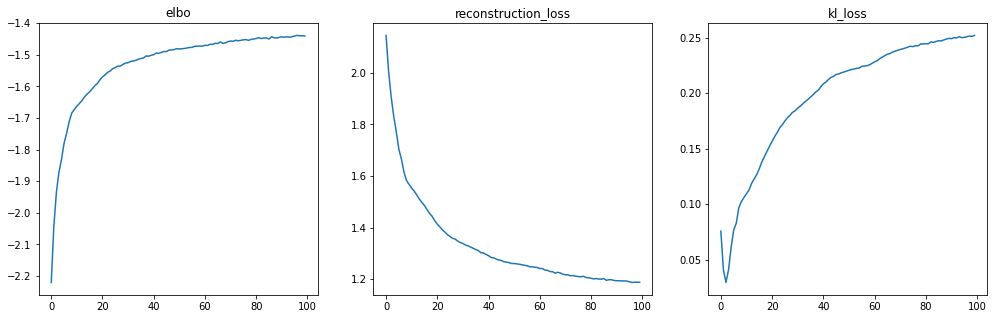

In [277]:
df = pd.DataFrame(hist.history)
fig, axs = plt.subplots(1, 3, figsize=(17, 5))
df['elbo'].plot(ax=axs[0], title="elbo")
df['reconstruction_loss'].plot(ax=axs[1], title="reconstruction_loss")
df['kl_loss'].plot(ax=axs[2], title="kl_loss")

plt.savefig('tt_20k_100epochs.png')

In [264]:
# df.to_csv('tt_20k_100epochs.csv')
cs.evaluate(x_val, y_val)

61/61 [==============================] - 1s 23ms/step - elbo: -1.1029 - reconstruction_loss: 0.8729 - kl_loss: 0.2296


[-1.1028738021850586, 0.22964993119239807, 0.8728943467140198]

In [268]:
_, _, z = cs.encode(x_train)
reconstructions = cs.decode(z, True).numpy()

print(reconstructions.shape)
print(np.argmax(reconstructions[0], axis=1))

for original, reconstruction in zip(y_train[:10], reconstructions[:10]):
    a = np.argmax(original, axis=1)
    b = np.argmax(reconstruction, axis=1)
    print('o: ', a)
    print('r: ', b)
    print('-----------------------------------')

correct = 0
for original, reconstruction in zip(y_train, reconstructions):
    a = np.argmax(original, axis=1)
    b = np.argmax(reconstruction, axis=1)

    if np.array_equiv(a, b):
        correct += 1
       
print(f"{correct} of {len(z)} reconstructed. Accuracy is {correct / len(z)}")

(17361, 16, 90)
[72  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
o:  [89  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0]
r:  [72  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
-----------------------------------
o:  [88  0  1  0 23  0  0  0 26  0  0  0  0  0  0  1]
r:  [11  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
-----------------------------------
o:  [87 81  0  0  0  0  1  0  0  0  0  0 89  0 79  0]
r:  [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 84  0]
-----------------------------------
o:  [87  0 71  0 81  1 83  1 81  0 83  1 83  1 79  0]
r:  [ 0  0  0  0 83  1 83  1 83  0 83  1 83  0 83  0]
-----------------------------------
o:  [86  0 87  0 87  0 79  0 84  0  0  0 86 88 84  0]
r:  [80  0 82  0 79  0 79  0 79  0  0  0 79  0  0  0]
-----------------------------------
o:  [86  0 77  0 28  0 77  0  0  0  0  0  0  0 82  0]
r:  [37  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
-----------------------------------
o:  [86  0  0  0 84  0  0  0 20  0  0  0  0  0  0  1]
r:  [15  0  0  0

In [279]:
budget = 500

# data = generate_midi_data(5, 16)
new_y = x_val[:10]
new_x = y_val[:10]

missclassifieds = 1
while missclassifieds > 0 and budget > 0:
    missclassifieds = 0
    history = cs.fit(new_x, new_y, epochs=1, batch_size=10)

    reconstructions = cs.predict(new_x)

    for original, reconstruction in zip(new_y, reconstructions):

        a = np.argmax(original, axis=1)
        b = np.argmax(reconstruction, axis=1)

        if not np.array_equiv(a, b):
            missclassifieds += 1

    budget -= 1

print(missclassifieds, budget)

TypeError: choice() got an unexpected keyword argument 'k'

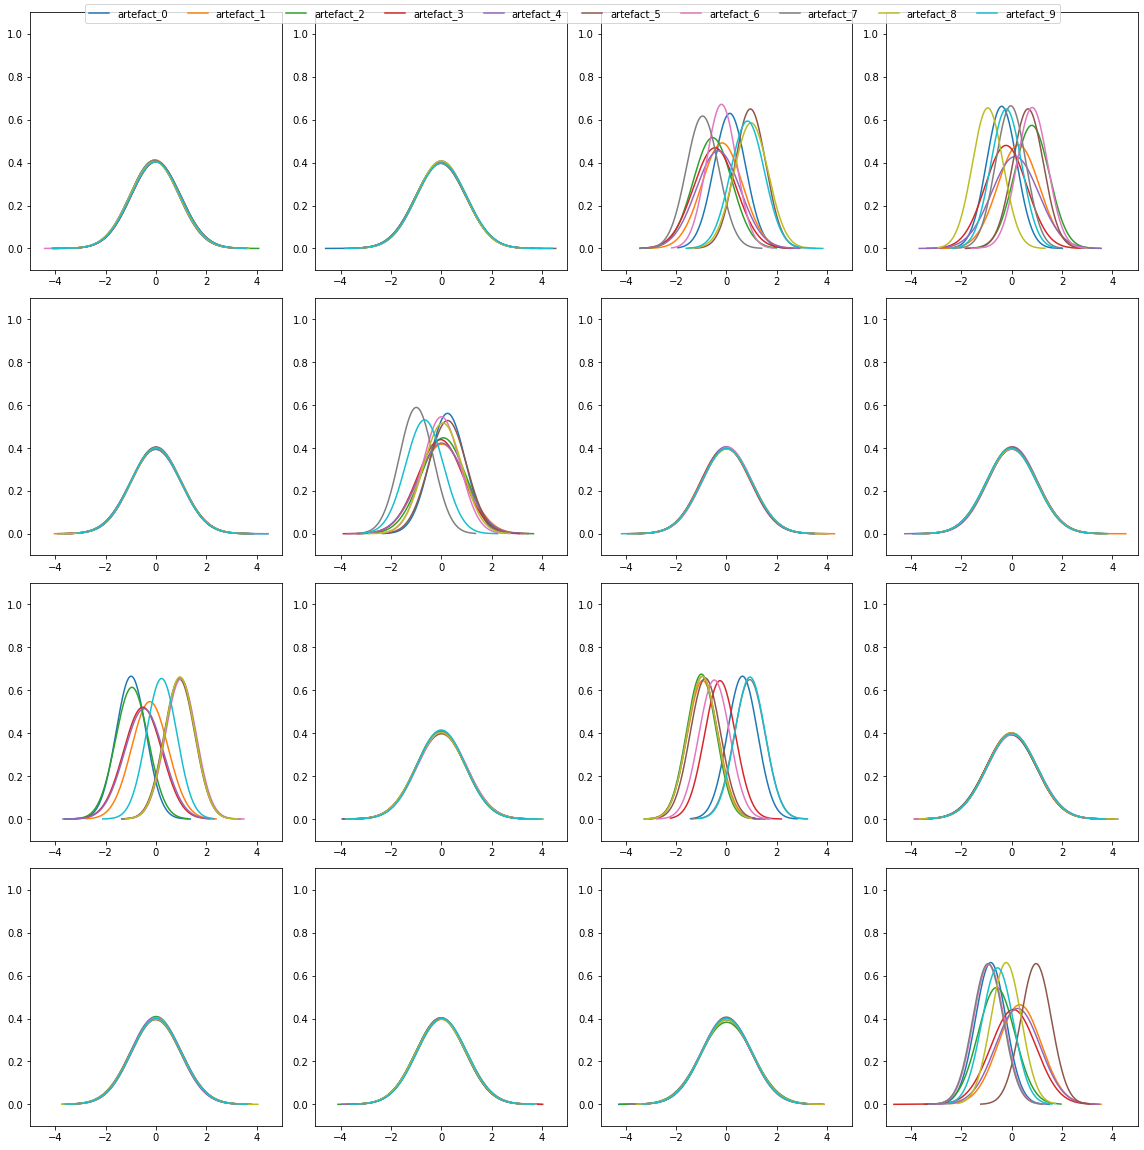

In [272]:
from scipy.stats import norm

selected_x = new_x
z_mean, z_logvar, z = cs.encode(selected_x)

fig, axs = plt.subplots(4, 4, figsize=(4 * 4, 4 * 4))
labels = [f"artefact_{i}" for i in range(0, len(selected_x))]

for i, ax in enumerate(axs.flatten()):

    for j in range(0, len(selected_x)):
        std = np.exp(0.5 * z_logvar[j][i]) # make the plots a bit saner
        h = sorted(np.random.normal(z_mean[j][i], std, 5000))
        pdf = norm.pdf(h, np.mean(h), np.std(h))
        ax.plot(h, pdf, label=labels[j])   
    
    ax.set_ylim(-0.1, 1.1)
    ax.set_xlim(-5, 5)

fig.legend(loc="upper center", labels=labels, ncol=len(new_x))
plt.tight_layout()
plt.show()

In [244]:
a = new_y[3]
b = new_y[7]

z_a = z[3]
z_b = z[7]

interpolated_z = interpolate(z_a, z_b, 10)

print(np.argmax(a[::-1], axis=1))
print('-' * 45 + ' FROM ' + '-' * 45)

i_artefacts = cs.decode(interpolated_z, True).numpy()

for i_a in i_artefacts:
    print(np.argmax(i_a, axis=1))

print('-' * 46 + ' TO ' + '-' * 46)
print(np.argmax(b[::-1], axis=1))

[ 0  0  0  0  0 47  0  0  0  0  0  0  0  1  0  0]
--------------------------------------------- FROM ---------------------------------------------
[ 0  0  0  0  0 47  0  0  0  0  0  0  0  1  0  0]
[ 0  0  0  0  0 47  0  0  0  0  0  0  0  1  0  0]
[ 0  0  0  0  0 47  0  0  0  0  0  0  0  1  0  0]
[ 0  0  0  0  0 46  0  0  0  0  0  0  0  1  0  0]
[ 0  0  0  0  0 46  0  0  0  0  0  0  0  1 44  0]
[ 0  0  0  0  0 46  0  0  0  0  0  0  0  1 44  0]
[ 0  0  0  0  0 46  0  0  0  0  0  0  0  1 44  0]
[ 0  0  0  0  0 46  0  0  0  0  0  0  0  1 44  0]
[ 0  0  0  0  0 46  0  0  0  0  0 43  0  1 44  0]
[ 0  0  0  0  0 46  0  0  0  0  0 43  0  1 44  0]
---------------------------------------------- TO ----------------------------------------------
[ 0  0  0  0  0 46 46  0  0  0  0 43  0  1 44  0]
